# Web scraping job ads

Goal: apply web scraping to obtain information about currently available jobs from th Swiss website www.jobs.ch, which publishes job ads and aggregates ads from company websites.

Methods: use BeautifulSoup (https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to get the information from the website's HTML code, analyze job ads

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from os import path
import requests

from bs4 import BeautifulSoup # for the actual web scraping
import math # for rounding
import re # regular expressions for filtering of links
from tqdm import tqdm # status bar

# for graphs
import seaborn as sns 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Set up access to main website

https://www.jobs.ch/en/vacancies/ shows all vacancies

To find out how to scrape the website, it has to be inspected first. This is best done using the "inspect element" option in a web browser.

In [2]:
# Create the link as a composite
link_first_part = 'https://www.jobs.ch'


url = link_first_part + "/en/"

# get the content from the link
response = requests.get(url, timeout=50)

# parse the content with BeautifulSoup with the html.parser method
soup = BeautifulSoup(response.content, "html.parser")

# check status code of the loaded page, it should return 200 to indicate an accessible website
print(response.status_code)

# link path to each category
soup.findAll('div', {
             'class': 'category-list x--category-list margin-bottom-4 margin-bottom-sm-6'})[0].find('a').get('href')

# [0].find('a').get('href')
length = len(soup.find('ul', {"class": "list-links-unstyled"}).findAll("li"))
job_links = []
for e in range(length):
    job_links.append(link_first_part + soup.find('ul',
                                                 {"class": "list-links-unstyled"}).findAll("li")[e].find('a').get('href'))

job_links # this will return a list showing all the main job category links

200


['https://www.jobs.ch/en/vacancies/admin-hr-consulting-ceo/',
 'https://www.jobs.ch/en/vacancies/banking-insurance/',
 'https://www.jobs.ch/en/vacancies/catering-food-tourism/',
 'https://www.jobs.ch/en/vacancies/chemical-pharma-biotechnology/',
 'https://www.jobs.ch/en/vacancies/construction-architecture-engineer/',
 'https://www.jobs.ch/en/vacancies/electronics-engineering-watches/',
 'https://www.jobs.ch/en/vacancies/finance-trusts-real-estate/',
 'https://www.jobs.ch/en/vacancies/graphic-art-typography-printing/',
 'https://www.jobs.ch/en/vacancies/information-technology-telecom/',
 'https://www.jobs.ch/en/vacancies/machine-plant-engin-manufacturing/',
 'https://www.jobs.ch/en/vacancies/medicine-care-therapy/',
 'https://www.jobs.ch/en/vacancies/marketing-communications-editorial/',
 'https://www.jobs.ch/en/vacancies/public-admin-education-social/',
 'https://www.jobs.ch/en/vacancies/purchasing-logistics-trading/',
 'https://www.jobs.ch/en/vacancies/sales-customer-service-admin/',


In [3]:
link = job_links[0] #set the link to be accessed
link # this will show the link to the first job category

'https://www.jobs.ch/en/vacancies/admin-hr-consulting-ceo/'

In [4]:
# for that link we load the page and parse it with BeautifulSoup
response = requests.get(link, timeout=50)
soup = BeautifulSoup(response.content, "html.parser")

## Number of jobs per category

In this part we will find the total number of jobs listed in each category.
The result will be added to a pandas dataframe.

In [5]:
# first, we get the number of jobs and job categories in one line

jobnr = []
dfall = pd.DataFrame()
for link in tqdm(job_links):  # tqdm gives a progress bar as it can take a while to run
    response = requests.get(link, timeout=50)
    soup = BeautifulSoup(response.content, "html.parser")
    try:
        jobnr = soup.find('span', {'class': 'x--page-header'}).get_text()

    except:
        jobnr = np.nan

    # we append the data to the dataframe
    dfall = dfall.append({
        'Date parsed': datetime.now().date(),
        'Jobs': jobnr,
    }, ignore_index=True)
    # before the end of the loop we introduce a time delay to respect others that want to access the website
    # not adding a delay can lead to your parsing being interrupted as the website may find your rate of access suspicious
    time.sleep(0.6)

100%|██████████| 18/18 [00:21<00:00,  1.33s/it]


In [6]:
dfall.head()

,Date parsed,Jobs
0,2019-06-30,8'299 Admin. / HR / Consulting / CEO job offers
1,2019-06-30,5'463 Banking / Insurance job offers
2,2019-06-30,3'133 Catering / Food / Tourism job offers
3,2019-06-30,1'443 Chemical / Pharma / Biotechnology job of...
4,2019-06-30,8'765 Construction / Architecture / Engineer j...


In [7]:
# since it's not very useful to have it in that format, regular expressions can be used to separate job categories and job numbers
# to create regular expressions, use https://regex101.com/ or similar to cross-check your expressions

dfnr = pd.DataFrame()  # initiate new, empty dataframe

# declare your regular expressions
regex1 = "(([0-9]\'[0-9]{0,4})|([0-9]{0,4}))" # will catch 0-9 and '
regex2 = "( job offers)" # will catch the string " job offers" in each category name
regex3 = "['A-Za-z&./]{1,}" # will catch everything except 0-9

dfnr["Date parsed"] = dfall["Date parsed"] # so you know how up-to-date your numbers are
dfnr["Categories"] = dfall.Jobs.replace(to_replace=(regex2, regex1), value='', regex=True)
dfnr["Jobs"] = dfall.Jobs.replace(to_replace=regex3, value='', regex=True)

In [8]:
# to see the type of your new dataframe's colums, use .info()
dfnr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
Date parsed    18 non-null object
Categories     18 non-null object
Jobs           18 non-null object
dtypes: object(3)
memory usage: 512.0+ bytes


In [9]:
# since there will be arithmetic manipulations, the number of jobs need to be in a numeric format
dfnr["Date parsed"] = pd.to_datetime(dfnr["Date parsed"])
dfnr["Jobs"] = pd.to_numeric(dfnr["Jobs"])

print(dfnr.dtypes)

# get the final dataframe with the sum of all jobs
totaljobs = {'Categories': "Total",
             'Jobs': dfnr['Jobs'].sum(),
             "Date parsed": ""}
dftotal = dfnr.append(totaljobs, ignore_index=True)

dftotal

Date parsed    datetime64[ns]
Categories             object
Jobs                    int64
dtype: object


,Date parsed,Categories,Jobs
0,2019-06-30 00:00:00,Admin. / HR / Consulting / CEO,8299
1,2019-06-30 00:00:00,Banking / Insurance,5463
2,2019-06-30 00:00:00,Catering / Food / Tourism,3133
3,2019-06-30 00:00:00,Chemical / Pharma / Biotechnology,1443
4,2019-06-30 00:00:00,Construction / Architecture / Engineer,8765
5,2019-06-30 00:00:00,Electronics / Engineering / Watches,3507
6,2019-06-30 00:00:00,Finance / Trusts / Real Estate,2904
7,2019-06-30 00:00:00,Graphic Art / Typography / Printing,315
8,2019-06-30 00:00:00,Information Technology / Telecom.,8212
9,2019-06-30 00:00:00,Machine / Plant Engin. / Manufacturing,4537


## Visualize jobs per category

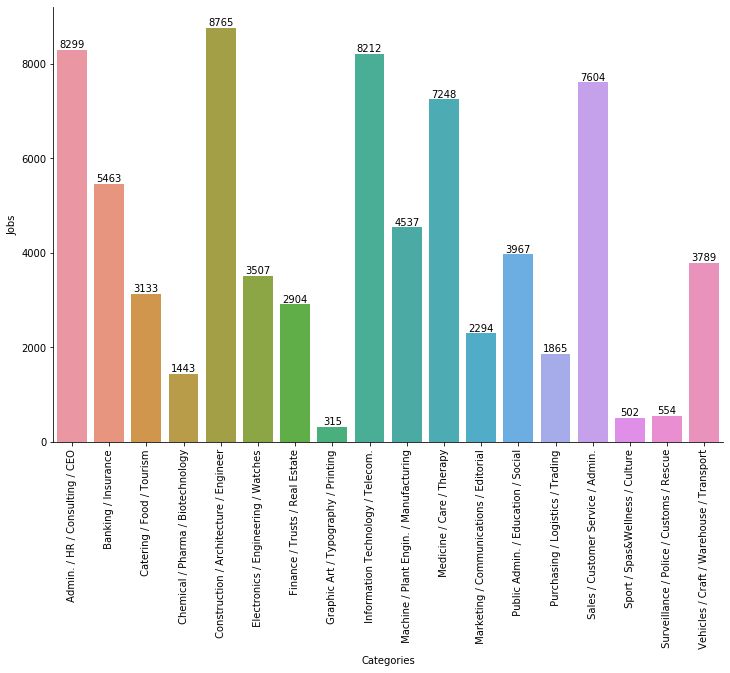

In [10]:
# make a plot using the seaborn library
fig, g = plt.subplots(figsize=(12, 8))
g = sns.barplot(data=dfnr, x="Categories", y="Jobs")
g.set_xticklabels(rotation=90, labels=dfnr["Categories"])

# add the count of jobs on top of each bar
for i, v in enumerate(dfnr["Jobs"].iteritems()):
    g.text(i, v[1], "{:}".format(v[1]), color='black',
           ha="center", va='bottom', rotation=0)

# remove top and right axis for aesthetic reasons
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

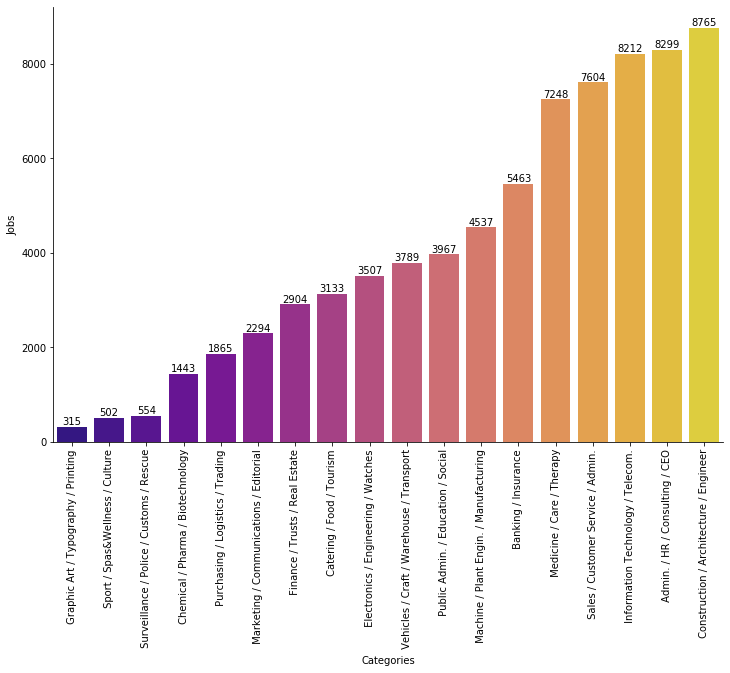

In [11]:
# sort by number of jobs

dfnr_sorted = dfnr.sort_values(['Jobs']).reset_index(drop=True)
#print (dfnr_sorted)

# visualize sorted table and apply color gradient
plt.figure(figsize=(12, 8))
g = sns.barplot(y="Jobs", x="Categories", data=dfnr_sorted, palette=("plasma"))

g.set_xticklabels(rotation=90, labels=dfnr_sorted["Categories"])

# add the count of jobs on top of each bar
for i, v in enumerate(dfnr_sorted["Jobs"].iteritems()):
    g.text(i, v[1], "{:}".format(v[1]), color='black',
           va='bottom', ha="center", rotation=0)


# remove top and right axis for aesthetic reasons
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

# Number of pages

Here, the goal is to find how many pages of jobs there are in each category and print the results to a csv file

In [12]:
allnumbers = pd.to_numeric(dfnr['Jobs'].sum())  # total number of jobs
allnumbersp = allnumbers.item()
type(allnumbersp)  # it needs to be in the int format for the upcoming math

int

In [13]:
# there are 24 job ads per page, so the total number of pages can be found by simple division
allpages=(math.ceil(allnumbersp/24)) #always round up, as ther are no half-pages
print("There are " +str(allpages) +" pages job ads right now")

There are 3101 pages job ads right now


In [14]:
# find the number of pages per category and add it to the dataframe

dftotal["Pages1"] = dftotal['Jobs'] # create new column with "job" values

dfToList = dftotal["Pages1"].tolist() # cast new column to list

dfList = list(dftotal['Pages1'])

dfValues = dftotal['Pages1'].values

p = []  # initiate p for the number of pages coming out of the for-loop
for i in dfValues:
    p.append(math.ceil(i/24))

pdpage = pd.DataFrame([p], [0])

pdpaget = pdpage.transpose()
pdpaget.rename(columns={0: "Pages"}, inplace=True)
pdpaget

# join the dataframes
total = pd.concat([dftotal, pdpaget], axis=1)

# remove the helper column "Pages1"
total.drop(["Pages1"], axis=1)

,Date parsed,Categories,Jobs,Pages
0,2019-06-30 00:00:00,Admin. / HR / Consulting / CEO,8299,346
1,2019-06-30 00:00:00,Banking / Insurance,5463,228
2,2019-06-30 00:00:00,Catering / Food / Tourism,3133,131
3,2019-06-30 00:00:00,Chemical / Pharma / Biotechnology,1443,61
4,2019-06-30 00:00:00,Construction / Architecture / Engineer,8765,366
5,2019-06-30 00:00:00,Electronics / Engineering / Watches,3507,147
6,2019-06-30 00:00:00,Finance / Trusts / Real Estate,2904,121
7,2019-06-30 00:00:00,Graphic Art / Typography / Printing,315,14
8,2019-06-30 00:00:00,Information Technology / Telecom.,8212,343
9,2019-06-30 00:00:00,Machine / Plant Engin. / Manufacturing,4537,190


In [15]:
# print dataframe to csv file in current directory
# no index numbers
# with header of columns

total_pages_csv = total.to_csv('total_job_pages.csv', index=None, header=True)